# Scaling, Random Forest with Grid Search

Results are not good.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
)
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv("dataset-clean-withNAs.csv")
df = df.drop(columns=["Unnamed: 0"])

In [3]:
df = df.fillna(0)

In [4]:
X = df.drop("SARS-Cov-2 exam result", axis=1)
y = df["SARS-Cov-2 exam result"]

In [5]:
# scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit_transform(X)

array([[0.68421053, 0.62832804, 0.61925487, ..., 0.        , 0.        ,
        0.        ],
       [0.89473684, 0.66134191, 0.61607135, ..., 0.        , 0.        ,
        0.        ],
       [0.42105263, 0.62832804, 0.61925487, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.21052632, 0.62832804, 0.61925487, ..., 0.        , 0.        ,
        0.        ],
       [0.52631579, 0.62832804, 0.61925487, ..., 0.        , 0.        ,
        1.        ],
       [1.        , 0.72523967, 0.69642853, ..., 0.        , 0.        ,
        0.        ]])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(y_train.value_counts())
print(y_test.value_counts())

0    4065
1     450
Name: SARS-Cov-2 exam result, dtype: int64
0    1021
1     108
Name: SARS-Cov-2 exam result, dtype: int64


In [7]:
X_train.columns

Index(['Patient age quantile', 'Hematocrit', 'Hemoglobin', 'Platelets',
       'Mean platelet volume ', 'Red blood Cells', 'Lymphocytes',
       'Mean corpuscular hemoglobin concentration (MCHC)', 'Leukocytes',
       'Basophils', 'Mean corpuscular hemoglobin (MCH)', 'Eosinophils',
       'Mean corpuscular volume (MCV)', 'Monocytes',
       'Red blood cell distribution width (RDW)', 'Serum Glucose',
       'Neutrophils', 'Urea', 'Proteina C reativa mg/dL', 'Creatinine',
       'Potassium', 'Sodium', 'Alanine transaminase', 'Aspartate transaminase',
       'Gamma-glutamyltransferase ', 'Total Bilirubin', 'Direct Bilirubin',
       'Indirect Bilirubin', 'Alkaline phosphatase', 'Ionized calcium ',
       'Magnesium', 'pCO2 (venous blood gas analysis)',
       'Hb saturation (venous blood gas analysis)',
       'Base excess (venous blood gas analysis)',
       'pO2 (venous blood gas analysis)',
       'Total CO2 (venous blood gas analysis)',
       'pH (venous blood gas analysis)', 'HCO3 (

In [8]:
# from sklearn.feature_selection import SelectFromModel
# from sklearn.tree import DecisionTreeClassifier

# print(X_train.shape)
# selector = SelectFromModel(estimator=DecisionTreeClassifier(random_state=42)).fit(X_train, y_train)

# feature_idx = selector.get_support()
# feature_name = X.columns[feature_idx]

# X_train = selector.transform(X_train)
# X_train = pd.DataFrame(X_train, columns=feature_name)

# X_test = selector.transform(X_test)
# X_test = pd.DataFrame(X_test, columns=feature_name)

# print(X_train.shape)
# print(feature_name)

In [9]:
def _extract_feature_importance(model, features):
    if not hasattr(model, "coef_") and not hasattr(model, "feature_importances_"):
        raise Exception("Not possible to collect feature importances")

    if hasattr(model, "coef_"):
        model_feature_importances = model.coef_[0]
    elif hasattr(model, "feature_importances_"):
        model_feature_importances = model.feature_importances_

    return [
        (feature, importance)
        for feature, importance in sorted(
            zip(features, model_feature_importances),
            key=lambda pair: pair[1],
            reverse=True,
        )
    ]

def run_cv(X_train, y_train, X_test, y_test, which_model):

    K_FOLD_ITERATIONS = 10

    search = GridSearchCV(
        which_model["model"], 
        which_model["params_to_tune"], 
        scoring=["precision", "recall", "roc_auc"],
        refit="roc_auc",
        cv=StratifiedKFold(
            n_splits=K_FOLD_ITERATIONS, 
            shuffle=True),  
        n_jobs=-1)
    
    search.fit(X_train, y_train)
    
    model = search.best_estimator_

    # let us just print the performance on the train set
    predictions_train = model.predict(X_train)
    train_results = {
        "prec": precision_score(y_train, predictions_train),
        "rec": recall_score(y_train, predictions_train),
        "roc": roc_auc_score(y_train, predictions_train),
    }
    cm_train = confusion_matrix(y_train, predictions_train)
    
    # in the test set
    predictions_test = model.predict(X_test)
    test_results = {
        "prec": precision_score(y_test, predictions_test),
        "rec": recall_score(y_test, predictions_test),
        "roc": roc_auc_score(y_test, predictions_test),
    }

    cm_test = confusion_matrix(y_test, predictions_test)
    
    # feature importance
    feature_importance = _extract_feature_importance(model, X_train.columns.values)
    
    return {
        "test_results": test_results, 
        "train_results": train_results, 
        "test_cm" : cm_test,
        "train_cm" : cm_train,
        "feature_importance": feature_importance,
        "y_pred": predictions_test
    }


from sklearn.metrics import classification_report

def print_result(result, fi=True):
    print("Results in the training set")
    print(result["train_results"])
    print(result["train_cm"])
    print("Results in the test set")
    print(result["test_results"])
    print(result["test_cm"])
    
    print("Report:")
    print(classification_report(y_test,result["y_pred"]))
    
    if fi:
        print("Feature importances")
        pd_fi = pd.DataFrame(result["feature_importance"], columns=["feature", "importance"])
        pd_fi = pd_fi[(pd_fi.importance > 0.01)]

        p = plt.barh(pd_fi["feature"], pd_fi["importance"])
        print(p)    

In [10]:
rf_model = {
    "model": RandomForestClassifier(random_state=42),
    "params_to_tune": {
        "max_depth": [3, 6, 12, 24, None],
        "max_features": ["auto", "sqrt", "log2", None],
        "min_samples_split": [2, 3, 4, 5, 10],
        "bootstrap": [True, False],
        "criterion": ["gini", "entropy"],
        "n_estimators": [10, 50, 100, 150, 200]
    }
}

In [11]:
result = run_cv(X_train, y_train, X_test, y_test, rf_model)

Results in the training set
{'prec': 1.0, 'rec': 0.14888888888888888, 'roc': 0.5744444444444444}
[[4065    0]
 [ 383   67]]
Results in the test set
{'prec': 0.6666666666666666, 'rec': 0.05555555555555555, 'roc': 0.5263086298835564}
[[1018    3]
 [ 102    6]]
Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1021
           1       0.67      0.06      0.10       108

    accuracy                           0.91      1129
   macro avg       0.79      0.53      0.53      1129
weighted avg       0.89      0.91      0.87      1129

Feature importances
<BarContainer object of 21 artists>


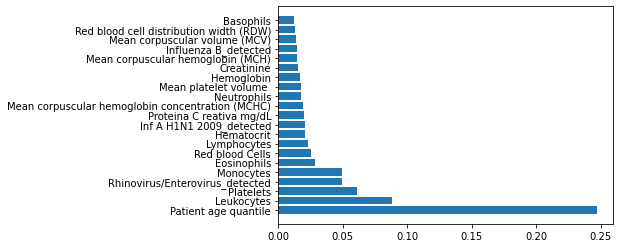

In [12]:
print_result(result)